## Setup Environments

### Mount Drive and Setup Project Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir="your-project-directory"

In [ ]:
project_dir="/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements"

In [ ]:
%cd {project_dir}

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [ ]:
# GPU Check
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, f"({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "")

Using device: cuda (Tesla T4)


In [ ]:
!nvidia-smi

Sat May 24 14:07:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## MNIST Dataset

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Create transform to resize (32, 32) and Normalize [-1, 1]
transform = transforms.Compose([
    transforms.Resize((32, 32)), # LeNet-5 ใช้ 32×32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # ทำให้ภาพอยู่ในช่วง [-1, 1]
])

In [ ]:
# Load MNIST
train_val_dataset = MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="data", train=False, download=True, transform=transform)

In [ ]:
# Split training / eval set (90% / 10%)
train_len = int(len(train_val_dataset) * 0.9)
eval_len = len(train_val_dataset) - train_len
train_dataset, eval_dataset = random_split(train_val_dataset, [train_len, eval_len])

In [ ]:
print(f"Dataset Split:\n - Train: {len(train_dataset)}\n - Eval: {len(eval_dataset)}\n - Test: {len(test_dataset)}")

Dataset Split:
 - Train: 54000
 - Eval: 6000
 - Test: 10000


### Display MNIST Dataset

In [ ]:
def show_mnist_before_after_aligned(before_dataset, after_dataset, indices=None, num_images=10):
    if indices is None:
        indices = list(range(num_images))

    plt.figure(figsize=(num_images * 1.3, 4))

    for i, idx in enumerate(indices):
        image_before, label_before = before_dataset[idx]
        image_after, label_after = after_dataset[idx]

        # BEFORE (raw pixel)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image_before, cmap="gray")
        plt.title(f"Before\n{label_before}")
        plt.axis("off")

        # AFTER (transformed)
        image_after_np = image_after.squeeze(0).numpy()
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(image_after_np, cmap="gray")
        plt.title(f"After\n{label_after}")
        plt.axis("off")

    plt.suptitle("MNIST: Before vs After Transform (Same Image)", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# โหลด Before dataset (ไม่มี transform)
mnist_before = MNIST(root="data", train=True, download=False, transform=None)

# after = dataset ที่ผ่าน resize(32,32) + normalize แล้ว
mnist_after = train_val_dataset

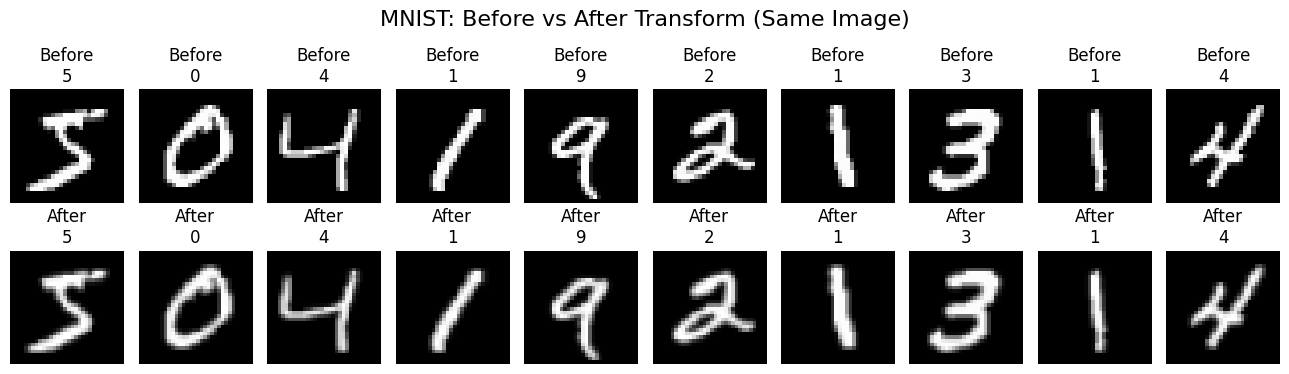

In [ ]:
# ดึงภาพ 10 ภาพแรก (index 0–9) เพื่อเปรียบเทียบ
show_mnist_before_after_aligned(mnist_before, mnist_after, indices=list(range(10)))

### DataLoder

In [ ]:
# set batch size
BATCH_SIZE = 64

# Load dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Define LeNet5 Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        # Feature Extractor (Backbone)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) # gray scale input, 6 features
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) # downsampling with average pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # 16 features
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) # downsampling with average pooling
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5) # 120 features

        # Classifier (Fully Connected)
        self.fc1 = nn.Linear(120, 84) # 120 vectors to 84 neurons
        self.fc2 = nn.Linear(84, num_classes) # 84 neurons to 10 classes

    def forward(self, x):
        # input = [1, 32, 32]

        # Feature Extractor (Backbone)
        x = F.relu(self.conv1(x)) # Conv + ReLU
        x = self.pool1(x) # AvgPool
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x)) # Output: [batch, 120, 1, 1]

        # Classifier (Fully Connected)
        x = x.view(x.size(0), -1) # flatten เป็น [batch, 120]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Create a Model
model = LeNet5().to(device) # move to GPU

#### Model Summary

In [ ]:
!pip install -q torchsummary

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


## Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

In [ ]:
# Loss และ Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Helper to Calculate Accuracy
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)

In [ ]:
# Logging
train_losses, eval_losses = [], []
train_accuracies, eval_accuracies = [], []

In [ ]:
# epochs
NUM_EPOCHS = 20

In [ ]:
total_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    train_loop = tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]")
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Logging
        running_loss += loss.item() * inputs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = running_correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- EVAL ----
    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * inputs.size(0)
            eval_correct += (outputs.argmax(1) == labels).sum().item()
            eval_total += labels.size(0)

    eval_loss = eval_loss / eval_total
    eval_acc = eval_correct / eval_total
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_acc)

    end_time = time.time()
    print(f"Epoch {epoch+1} Summary | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f} | Time: {end_time - start_time:.2f}s")

total_time = time.time() - total_start_time
print(f"\nFinish training on time: {total_time/60:.2f} Min.")

[Train Epoch 1]: 100%|██████████| 844/844 [00:10<00:00, 81.71it/s, loss=0.0351] 


Epoch 1 Summary | Train Loss: 0.3030 | Train Acc: 0.9062 | Eval Loss: 0.0937 | Eval Acc: 0.9718 | Time: 11.38s


[Train Epoch 2]: 100%|██████████| 844/844 [00:08<00:00, 93.88it/s, loss=0.0391]


Epoch 2 Summary | Train Loss: 0.0767 | Train Acc: 0.9763 | Eval Loss: 0.0720 | Eval Acc: 0.9762 | Time: 9.92s


[Train Epoch 3]: 100%|██████████| 844/844 [00:08<00:00, 96.78it/s, loss=0.00873]


Epoch 3 Summary | Train Loss: 0.0553 | Train Acc: 0.9831 | Eval Loss: 0.0524 | Eval Acc: 0.9828 | Time: 9.78s


[Train Epoch 4]: 100%|██████████| 844/844 [00:08<00:00, 93.94it/s, loss=0.0124]


Epoch 4 Summary | Train Loss: 0.0427 | Train Acc: 0.9864 | Eval Loss: 0.0468 | Eval Acc: 0.9870 | Time: 9.99s


[Train Epoch 5]: 100%|██████████| 844/844 [00:09<00:00, 90.98it/s, loss=0.117] 


Epoch 5 Summary | Train Loss: 0.0365 | Train Acc: 0.9886 | Eval Loss: 0.0503 | Eval Acc: 0.9852 | Time: 10.23s


[Train Epoch 6]: 100%|██████████| 844/844 [00:09<00:00, 93.77it/s, loss=0.0101]


Epoch 6 Summary | Train Loss: 0.0312 | Train Acc: 0.9904 | Eval Loss: 0.0529 | Eval Acc: 0.9837 | Time: 9.98s


[Train Epoch 7]: 100%|██████████| 844/844 [00:09<00:00, 92.67it/s, loss=0.112]


Epoch 7 Summary | Train Loss: 0.0263 | Train Acc: 0.9916 | Eval Loss: 0.0426 | Eval Acc: 0.9877 | Time: 10.08s


[Train Epoch 8]: 100%|██████████| 844/844 [00:08<00:00, 95.60it/s, loss=0.00082]


Epoch 8 Summary | Train Loss: 0.0232 | Train Acc: 0.9929 | Eval Loss: 0.0436 | Eval Acc: 0.9873 | Time: 9.88s


[Train Epoch 9]: 100%|██████████| 844/844 [00:08<00:00, 94.58it/s, loss=0.0289] 


Epoch 9 Summary | Train Loss: 0.0203 | Train Acc: 0.9936 | Eval Loss: 0.0391 | Eval Acc: 0.9895 | Time: 9.85s


[Train Epoch 10]: 100%|██████████| 844/844 [00:09<00:00, 93.19it/s, loss=0.112] 


Epoch 10 Summary | Train Loss: 0.0183 | Train Acc: 0.9942 | Eval Loss: 0.0400 | Eval Acc: 0.9888 | Time: 10.01s


[Train Epoch 11]: 100%|██████████| 844/844 [00:09<00:00, 92.94it/s, loss=0.00159] 


Epoch 11 Summary | Train Loss: 0.0171 | Train Acc: 0.9944 | Eval Loss: 0.0395 | Eval Acc: 0.9903 | Time: 10.05s


[Train Epoch 12]: 100%|██████████| 844/844 [00:08<00:00, 94.17it/s, loss=0.00392]


Epoch 12 Summary | Train Loss: 0.0144 | Train Acc: 0.9953 | Eval Loss: 0.0365 | Eval Acc: 0.9905 | Time: 10.03s


[Train Epoch 13]: 100%|██████████| 844/844 [00:08<00:00, 94.94it/s, loss=0.00207]


Epoch 13 Summary | Train Loss: 0.0145 | Train Acc: 0.9953 | Eval Loss: 0.0386 | Eval Acc: 0.9895 | Time: 9.96s


[Train Epoch 14]: 100%|██████████| 844/844 [00:08<00:00, 94.61it/s, loss=0.0195]


Epoch 14 Summary | Train Loss: 0.0115 | Train Acc: 0.9964 | Eval Loss: 0.0531 | Eval Acc: 0.9863 | Time: 9.91s


[Train Epoch 15]: 100%|██████████| 844/844 [00:09<00:00, 90.51it/s, loss=0.00816]


Epoch 15 Summary | Train Loss: 0.0115 | Train Acc: 0.9959 | Eval Loss: 0.0403 | Eval Acc: 0.9908 | Time: 10.23s


[Train Epoch 16]: 100%|██████████| 844/844 [00:09<00:00, 93.22it/s, loss=0.00121]


Epoch 16 Summary | Train Loss: 0.0100 | Train Acc: 0.9968 | Eval Loss: 0.0502 | Eval Acc: 0.9905 | Time: 10.02s


[Train Epoch 17]: 100%|██████████| 844/844 [00:09<00:00, 93.75it/s, loss=0.000417] 


Epoch 17 Summary | Train Loss: 0.0090 | Train Acc: 0.9970 | Eval Loss: 0.0383 | Eval Acc: 0.9902 | Time: 9.97s


[Train Epoch 18]: 100%|██████████| 844/844 [00:08<00:00, 94.58it/s, loss=0.0145]


Epoch 18 Summary | Train Loss: 0.0096 | Train Acc: 0.9970 | Eval Loss: 0.0509 | Eval Acc: 0.9890 | Time: 9.91s


[Train Epoch 19]: 100%|██████████| 844/844 [00:08<00:00, 95.39it/s, loss=0.000675]


Epoch 19 Summary | Train Loss: 0.0075 | Train Acc: 0.9977 | Eval Loss: 0.0550 | Eval Acc: 0.9892 | Time: 9.82s


[Train Epoch 20]: 100%|██████████| 844/844 [00:09<00:00, 93.09it/s, loss=0.000198]


Epoch 20 Summary | Train Loss: 0.0074 | Train Acc: 0.9975 | Eval Loss: 0.0509 | Eval Acc: 0.9882 | Time: 10.10s

Finish training on time: 3.35 Min.


## Evaluate

 ### Plot Accuracy & Loss Graph

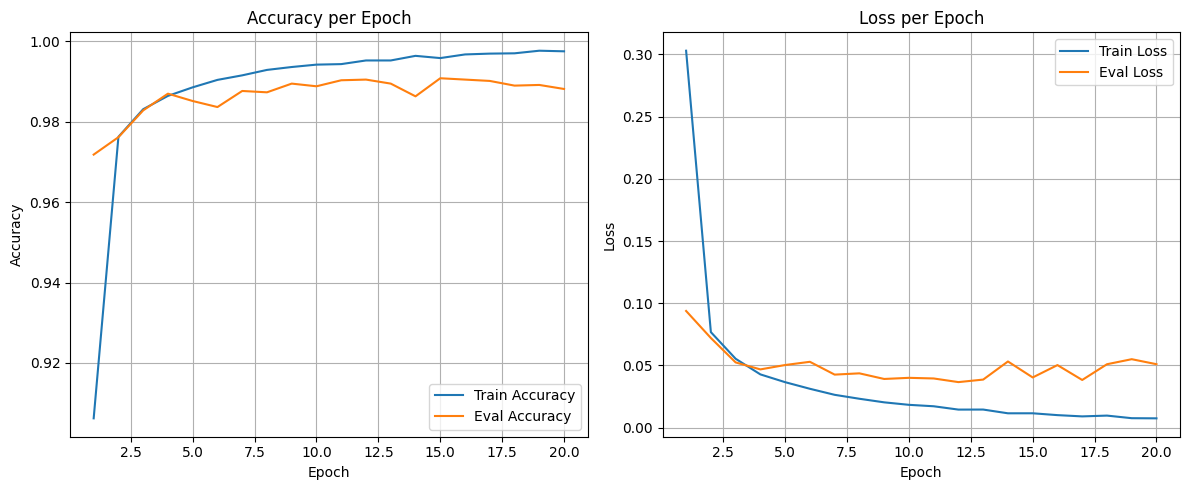

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, eval_accuracies, label='Eval Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, eval_losses, label='Eval Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import os
from sklearn.metrics import accuracy_score

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

Evaluating on Test Set: 100%|██████████| 157/157 [00:01<00:00, 99.44it/s] 


In [ ]:
test_accuracy = accuracy_score(all_targets, all_preds)
print(f"🎯 Final Test Accuracy: {test_accuracy:.4f}")

🎯 Final Test Accuracy: 0.9898


### Evaluation Metrics (Precision / Recall / F1-score)
> [วิธีอ่านค่า Evaluation Metrics (Confusion Matrix / Recall / Precision / F1-score)](https://github.com/morsetechlab/DeepVision-Classical-Models?tab=readme-ov-file#%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%AD%E0%B9%88%E0%B8%B2%E0%B8%99%E0%B8%84%E0%B9%88%E0%B8%B2-evaluation-metrics-precision--recall--f1-score)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_targets, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9969    0.9969    0.9969       980
           1     0.9973    0.9894    0.9934      1135
           2     0.9856    0.9932    0.9894      1032
           3     0.9673    0.9960    0.9815      1010
           4     0.9919    0.9939    0.9929       982
           5     0.9932    0.9776    0.9853       892
           6     0.9896    0.9906    0.9901       958
           7     0.9922    0.9912    0.9917      1028
           8     0.9948    0.9897    0.9923       974
           9     0.9900    0.9782    0.9840      1009

    accuracy                         0.9898     10000
   macro avg     0.9899    0.9897    0.9897     10000
weighted avg     0.9899    0.9898    0.9898     10000



### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))

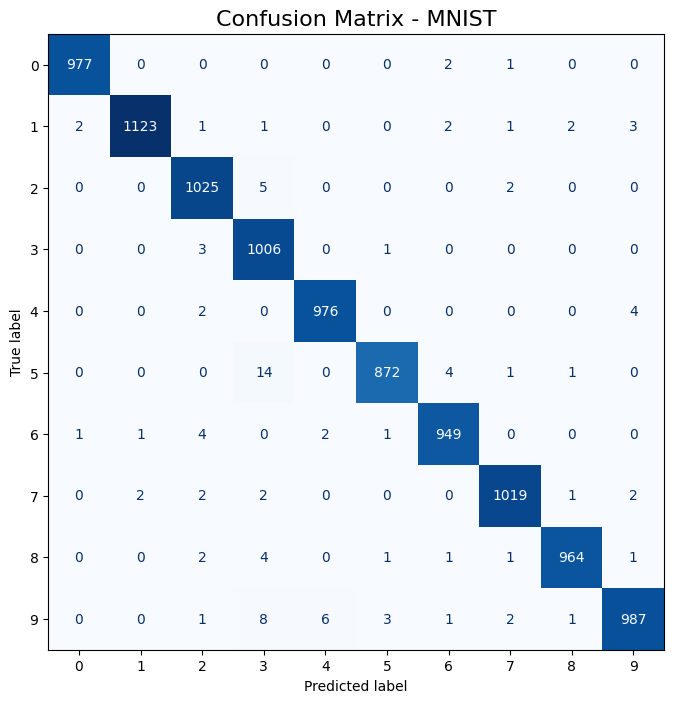

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - MNIST", fontsize=16)
plt.show()

## Random Inference

In [ ]:
import random
import numpy as np

def infer_random_images(model, dataset, n=5):
    model.eval()
    plt.figure(figsize=(15, 3))
    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()

        plt.subplot(1, n, i+1)
        plt.imshow(image.squeeze(0), cmap="gray")
        plt.title(f"GT: {label}\nPred: {pred}", fontsize=12, color='green' if pred == label else 'red')
        plt.axis("off")
    plt.suptitle("Random Inference", fontsize=16)
    plt.tight_layout()
    plt.show()

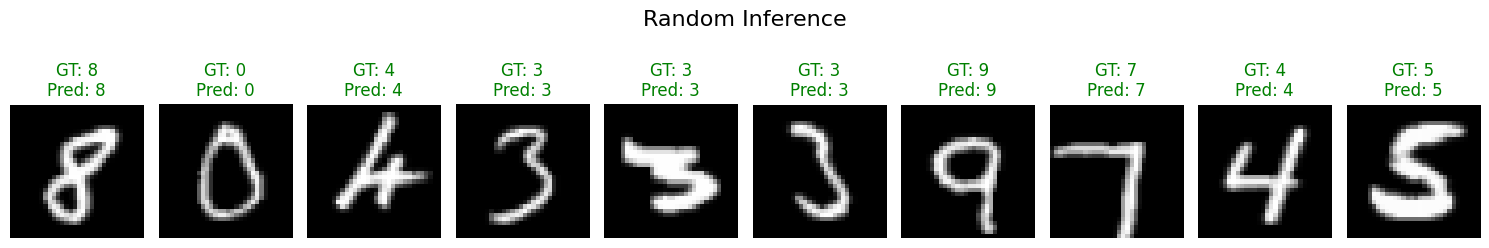

In [ ]:
infer_random_images(model, test_dataset, n=10)

## Export Model

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [ ]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "lenet5_mnist.pt")
torch.save(model.state_dict(), model_path)
print(f"Model Saved at {model_path}")

Model Saved at saved_models/lenet5_mnist.pt


## Load Model

In [ ]:
model = LeNet5(num_classes=10)
model.load_state_dict(torch.load(f"{project_dir}/saved_models/lenet5_mnist.pt"))

<All keys matched successfully>

In [ ]:
model.eval()

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)